In [12]:
from timm import create_model
model = create_model("densenet121", pretrained=True)
print("{:,}".format(sum([p.data.nelement() for p in model.parameters()])))
print('asdf')
# model = create_model("resnet50", pretrained=True)
# print("{:,}".format(sum([p.data.nelement() for p in model.parameters()])))

7,978,856
asdf


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seam_carving
seam_carving.carve.MAX_MEAN_ENERGY = 10.0
common = “data”
seed_everything(0)
import cv2
def get_img_path(data,):
    if data == “train”:
        train_data = pd.read_csv(“data/train.csv”)
        img_array = train_data[“img_path”].str.replace(“./“, “/”, regex = True).values
        refine_common = f”data/carving_train_img”
    else:
        test_data = pd.read_csv(“data/test.csv”)
        img_array = test_data[“img_path”].str.replace(“./“, “/”, regex = True).values
        refine_common = f”data/carving_test_img”
    return img_array, refine_common
def start(args):
    count = 1
    path_array, refine_common = get_img_path(args.action)
    for img_path in path_array:
        exist_data_path = common + img_path     # existing datapath
        img = np.asarray(Image.open(exist_data_path))
        img = seam_carving.resize(img, (100, 100))
        img = cv2.resize(img, (args.size, args.size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        folder_path = img_path.split(“/”)[-1].split(“.”)        # existing datapath
        new_data_path = os.path.join(refine_common, folder_path[0])     # existing datapath
        new_data_path += ‘.png’
        print(“--“)
        print(exist_data_path)
        print(new_data_path)
        print(“--“)
        cv2.imwrite(new_data_path, img)
        print(f”save data  {count}/ 1000 !“)
        count += 1
import argparse
if __name__ == “__main__“:
    parser = argparse.ArgumentParser()
    parser.add_argument(“--action”, type = str, required = True)        # train
    parser.add_argument(“--size”, type = int, required = True)        #
    args = parser.parse_args()
    start(args)

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_3277.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


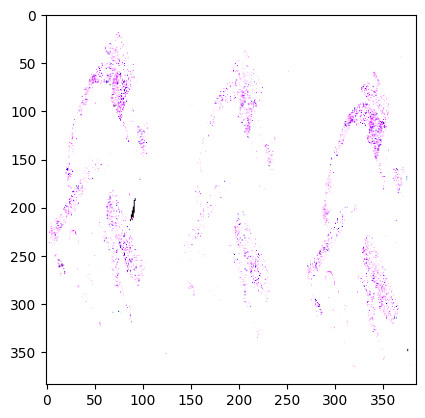

In [9]:
CFG = {
    'IMG_SIZE':384,
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':32,
    'SEED':41,
    "MODEL":"swin_base_patch4_window12_384",
    "gpu":"2,3",
    "momentum":0.9
}
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models
from timm import create_model
from customScheduler import CosineAnnealingWarmUpRestarts
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정




train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')




train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)



train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train_df.drop(columns=['N_category']), 
                                                    train_df['N_category'], 
                                                    test_size=0.2, 
                                                    random_state=CFG['SEED']
                                                )




def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))




class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None, test=False):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        self.test = test
        
    def __getitem__(self, index):
        if self.test:
            data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/test_imgs"
        else:
            data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs"
        img_path = os.path.join(data_path,self.medical_df["img_path"].iloc[index][-14:])
        print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)


# train_transforms = A.Compose([
#             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
#             A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=(0, 0.5), p=0.8),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.Sharpen(alpha=(0.2, 0.5), lightness=(0.2, 0.5), always_apply=False, p=1.0),
#             A.ColorJitter(brightness = 0.2, saturation = 0.5, hue = 0.5),
#             A.VerticalFlip(),
#             A.HorizontalFlip(),
#             ])


train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            # A.VerticalFlip(),
                            # A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])




train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
plt.imshow(train_dataset[0][0].permute(1,2,0))

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_0001.png

label:  0



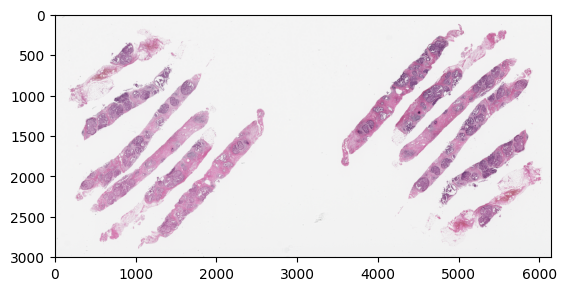

(3003, 6141, 3)

(3003, 6141, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


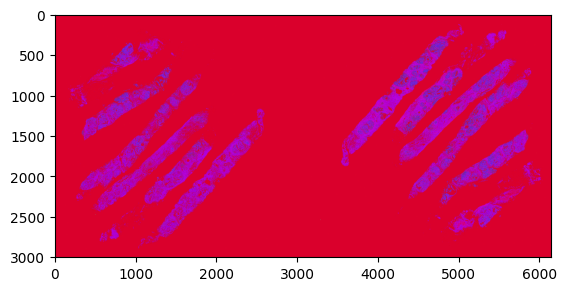

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *
from skimage import io
train_transforms = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=(0, 0.5), p=0.8),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.2, 0.5), always_apply=False, p=1.0),
            A.ColorJitter(brightness = 0.2, saturation = 0.5, hue = 0.5),
            A.VerticalFlip(),
            A.HorizontalFlip(),
            ])

i = 0
data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/"
img_path = os.path.join(data_path,train_df["img_path"][i][-14:])
print(img_path)
print()

print("label: ",train_df["N_category"][i])
print()

img = io.imread(img_path)
plt.imshow(img)
plt.show()
print(img.shape)
print()

x = train_transforms(image=img)["image"]
print(x.shape)
plt.imshow(x)
plt.show()

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_0002.png

label:  1



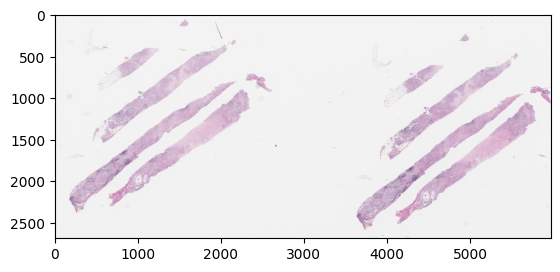

(2687, 5975, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2687, 5975, 3)


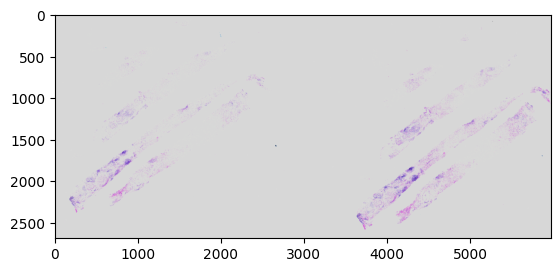

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *
from skimage import io
train_transforms = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=(0, 0.5), p=0.8),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.2, 0.5), always_apply=False, p=1.0),
            A.ColorJitter(brightness = 0.2, saturation = 0.5, hue = 0.5),
            A.VerticalFlip(),
            A.HorizontalFlip(),
            ])

i = 1
data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/"
img_path = os.path.join(data_path,train_df["img_path"][i][-14:])
print(img_path)
print()

print("label: ",train_df["N_category"][i])
print()

img = io.imread(img_path)
plt.imshow(img)
plt.show()
print(img.shape)
print()

x = train_transforms(image=img)["image"]
print(x.shape)
plt.imshow(x)
plt.show()

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_0003.png

label:  0



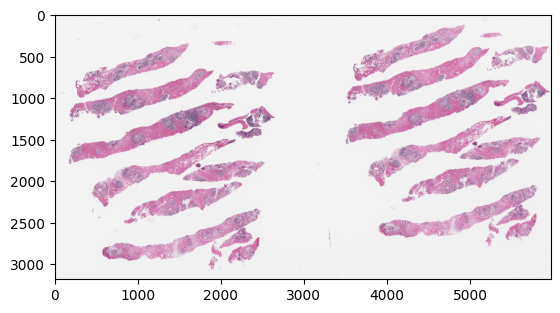

(3181, 5975, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3181, 5975, 3)


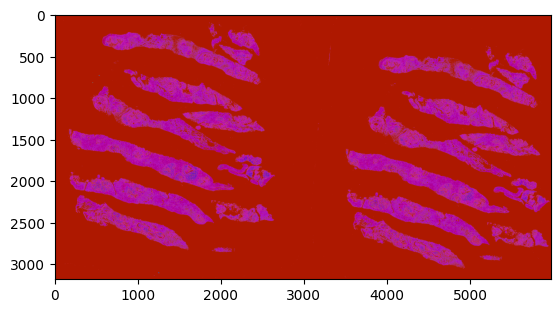

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *
from skimage import io
train_transforms = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=(0, 0.2), contrast_limit=(0, 0.5), p=0.8),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.2, 0.5), always_apply=False, p=1.0),
            A.ColorJitter(brightness = 0.2, saturation = 0.5, hue = 0.5),
            A.VerticalFlip(),
            A.HorizontalFlip(),
            ])

i = 2
data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/"
img_path = os.path.join(data_path,train_df["img_path"][i][-14:])
print(img_path)
print()

print("label: ",train_df["N_category"][i])
print()

img = io.imread(img_path)
plt.imshow(img)
plt.show()
print(img.shape)
print()

x = train_transforms(image=img)["image"]
print(x.shape)
plt.imshow(x)
plt.show()

In [2]:
import os
# print(traindf["img_path"].iloc[0])
data_path = "/home/ljj0512/shared/data/refine224_train_img/"
print(len(os.listdir(data_path)))
# print(os.path.join(data_path,traindf["img_path"].iloc[2][-14:]))

1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
BC_01_2993.npy
value: 2.0262864
(4, 224, 224, 3)
(224, 224, 3)
torch.Size([4, 3, 224, 224])


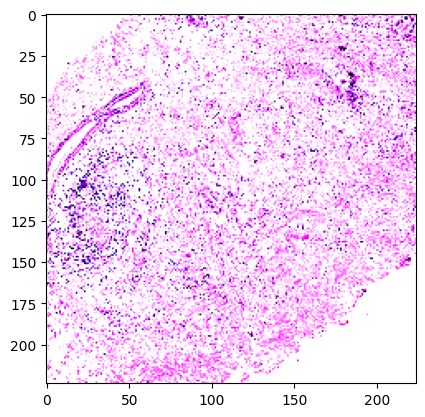

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


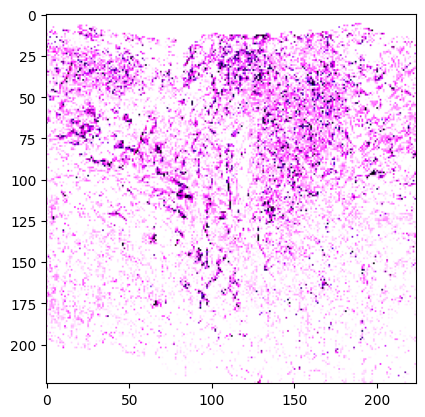

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


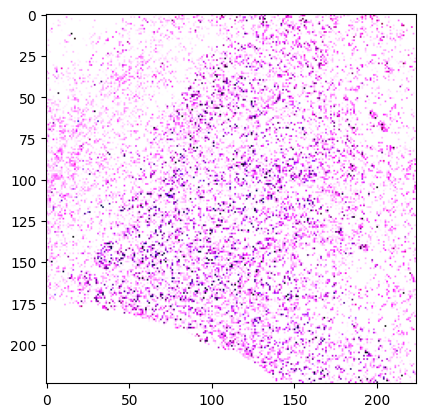

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


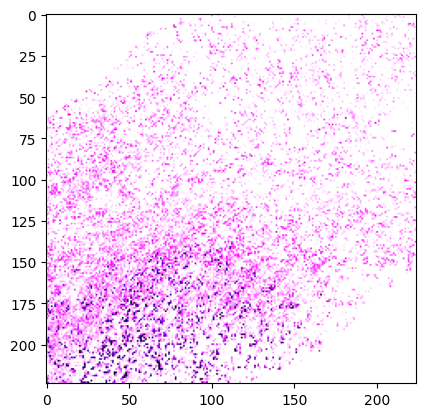

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *
train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            A.VerticalFlip(),
                            # A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            # A.Resize(224,512),
                            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])


data_path = "/home/ljj0512/shared/data/refine224_train_img/"
print(len(os.listdir(data_path)))
img_list = os.listdir(data_path)
print(img_list[0])

img = np.load(os.path.join(data_path,img_list[0]))

print("value:",img[0,0,0,0])
print(img.shape)
print(img[0].shape)
x = [train_transforms(image=img[0])["image"],
train_transforms(image=img[1])["image"],
train_transforms(image=img[2])["image"],
train_transforms(image=img[3])["image"]]
x = torch.stack(x)
print(x.shape)
plt.imshow(x[0].permute(1,2,0))
plt.show()
plt.imshow(x[1].permute(1,2,0))
plt.show()
plt.imshow(x[2].permute(1,2,0))
plt.show()
plt.imshow(x[3].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1001
BC_01_2993.npy
value: 242
(4, 256, 256, 3)
(256, 256, 3)
torch.Size([4, 3, 256, 256])


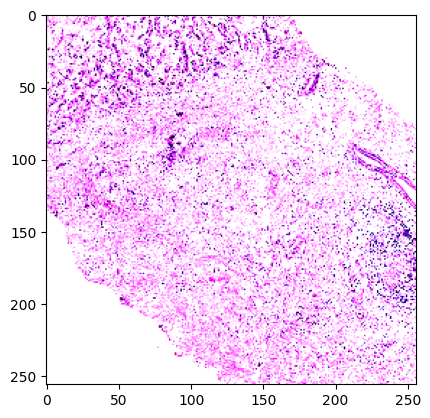

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


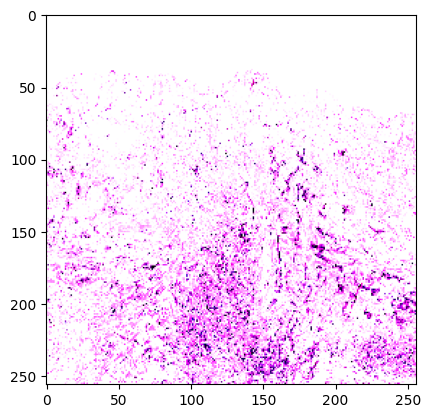

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


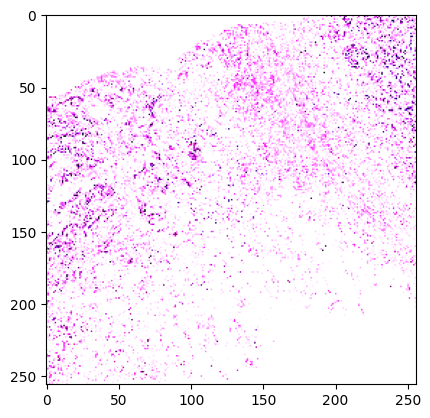

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


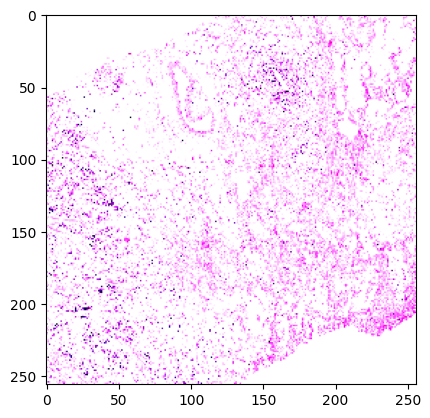

In [14]:
########### normalize
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *
train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            A.VerticalFlip(),
                            # A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            # A.Resize(224,512),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/refine_train_img/"
print(len(os.listdir(data_path)))
img_list = os.listdir(data_path)
print(img_list[0])

img = np.load(os.path.join(data_path,img_list[0]))

print("value:",img[0,0,0,0])
print(img.shape)
print(img[0].shape)
x = [train_transforms(image=img[0])["image"],
train_transforms(image=img[1])["image"],
train_transforms(image=img[2])["image"],
train_transforms(image=img[3])["image"]]
x = torch.stack(x)
print(x.shape)
plt.imshow(x[0].permute(1,2,0))
plt.show()
plt.imshow(x[1].permute(1,2,0))
plt.show()
plt.imshow(x[2].permute(1,2,0))
plt.show()
plt.imshow(x[3].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


250
BC_01_0507.npy
value 242
(4, 256, 256, 3)
(256, 256, 3)
torch.Size([4, 3, 256, 256])


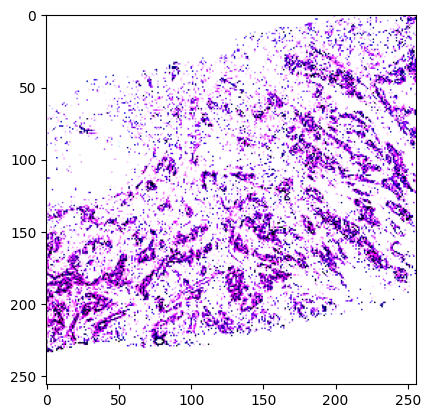

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


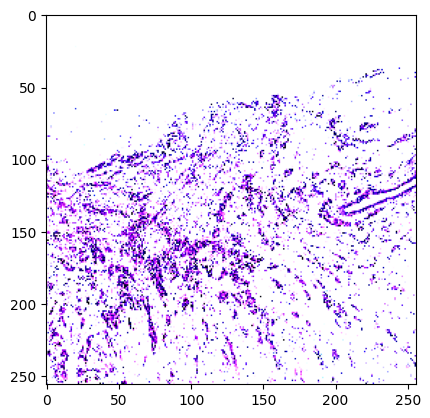

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


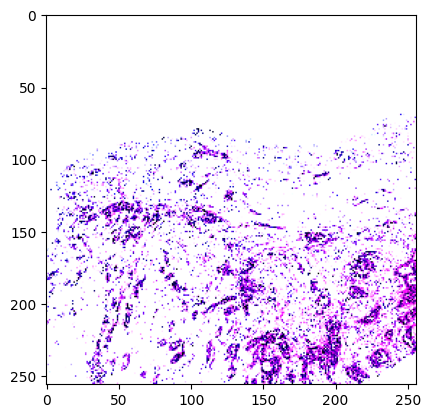

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


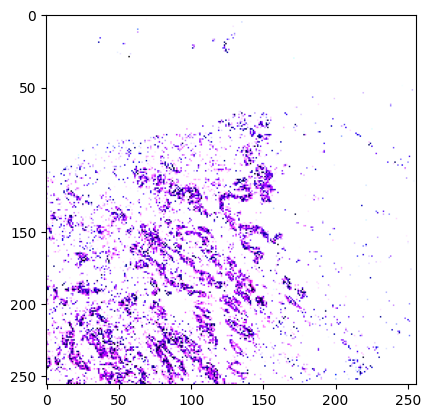

In [18]:
############ test set
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from preprocess import *

test_transforms = A.Compose([
                            # A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

data_path = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/refine_train_img/refine_test_img"
print(len(os.listdir(data_path)))
img_list = os.listdir(data_path)
print(img_list[0])

img = np.load(os.path.join(data_path,img_list[0]))

print("value", img[0,0,0,0])
print(img.shape)
print(img[0].shape)
x = [test_transforms(image=img[0])["image"],
test_transforms(image=img[1])["image"],
test_transforms(image=img[2])["image"],
test_transforms(image=img[3])["image"]]
x = torch.stack(x)
print(x.shape)
plt.imshow(x[0].permute(1,2,0))
plt.show()
plt.imshow(x[1].permute(1,2,0))
plt.show()
plt.imshow(x[2].permute(1,2,0))
plt.show()
plt.imshow(x[3].permute(1,2,0))
plt.show()
# x = test_transforms(image=img[0])
# print(len(x))
# # plt.show()
# plt.imshow(x['image'].permute(1,2,0))
# # plt.show()
# # plt.imshow(img[3])
# # plt.show()

In [1]:
import numpy as np
def make_tiles(img, tile_size=256, num_tiles=4):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    '''
    w, h, ch = img.shape
    pad0, pad1 = (tile_size - w%tile_size) % tile_size, (tile_size - h%tile_size) % tile_size
    padding = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    img = np.pad(img, padding, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    if len(img) < num_tiles: # pad images so that the output shape be the same
        padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
        img = np.pad(img, padding, mode='constant', constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    img = img[idxs]
    return img

In [47]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

CFG = {
    'IMG_SIZE':512,
    'EPOCHS':5,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

root_dir = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data"
train_df = pd.read_csv(root_dir+'/train.csv')
test_df = pd.read_csv(root_dir+'/test.csv')

train_df['암의 장경'] = train_df['암의 장경'].fillna(train_df['암의 장경'].mean())
train_df = train_df.fillna(0)

test_df['암의 장경'] = test_df['암의 장경'].fillna(train_df['암의 장경'].mean())
test_df = test_df.fillna(0)

train_df, val_df, train_labels, val_labels = train_test_split(train_df.drop(columns=['N_category']), 
                                                                train_df['N_category'], 
                                                                test_size=0.2, 
                                                                random_state=CFG["SEED"])

In [34]:
print(train_df.shape)
print(train_labels.shape)
print(val_df.shape)
print(val_labels.shape)

(800, 27)
(800,)
(200, 27)
(200,)


In [8]:

def get_values(value):
    return value.values.reshape(-1, 1)

numeric_cols = ['나이', '암의 장경', 'ER_Allred_score', 'PR_Allred_score', 'KI-67_LI_percent', 'HER2_SISH_ratio']
ignore_cols = ['ID', 'img_path', 'mask_path', '수술연월일', 'N_category']

for col in train_df.columns:
    if col in ignore_cols:
        continue
    if col in numeric_cols:
        scaler = StandardScaler()
        train_df[col] = scaler.fit_transform(get_values(train_df[col]))
        val_df[col] = scaler.transform(get_values(val_df[col]))
        test_df[col] = scaler.transform(get_values(test_df[col]))
    else:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(get_values(train_df[col]))
        val_df[col] = le.transform(get_values(val_df[col]))
        test_df[col] = le.transform(get_values(test_df[col]))

In [44]:
len(train_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[0])

23

In [45]:
train_df.iloc[0]

ID                                    BC_01_3277
img_path             ./train_imgs/BC_01_3277.png
mask_path                                      -
나이                                     -2.522114
수술연월일                                 2010-02-05
진단명                                            0
암의 위치                                          1
암의 개수                                          0
암의 장경                                  -0.793655
NG                                             3
HG                                             3
HG_score_1                                     3
HG_score_2                                     3
HG_score_3                                     3
DCIS_or_LCIS_여부                                0
DCIS_or_LCIS_type                              0
T_category                                     1
ER                                             1
ER_Allred_score                         0.017689
PR                                             1
PR_Allred_score     

In [29]:
class CustomDataset(Dataset):
    def __init__(self, medical_df, labels, transforms=None):
        self.medical_df = medical_df
        self.transforms = transforms
        self.labels = labels
        
    def __getitem__(self, index):
        root_dir = "/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data"
        img_path = self.medical_df['img_path'].iloc[index][2:]
        image = cv2.imread(os.path.join(root_dir,img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
                
        if self.labels is not None:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', 'mask_path', '수술연월일']).iloc[index])
            label = self.labels[index]
            return image, tabular, label
        else:
            tabular = torch.Tensor(self.medical_df.drop(columns=['ID', 'img_path', '수술연월일']).iloc[index])
            return image, tabular
        
    def __len__(self):
        return len(self.medical_df)

In [30]:
train_transforms = A.Compose([
                            A.HorizontalFlip(),
                            A.VerticalFlip(),
                            A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT,p=0.3),
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transforms = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [31]:
train_dataset = CustomDataset(train_df, train_labels.values, train_transforms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_df, val_labels.values, test_transforms)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [39]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(train_dataset[0][2])

torch.Size([3, 512, 512])
torch.Size([23])
()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


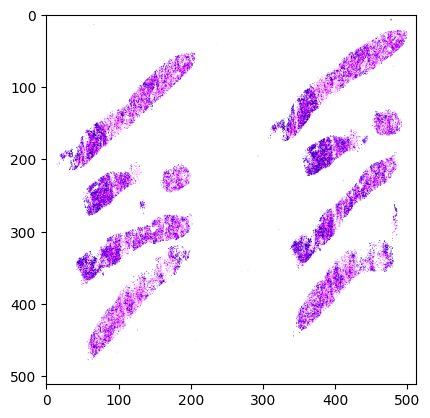

tensor([[ 7.1698e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00, -4.4193e-01,
          2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
          2.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  6.1988e-01,
          1.0000e+00,  7.0276e-01, -1.3982e-01,  0.0000e+00,  2.0000e+00,
          0.0000e+00,  6.9744e-01,  0.0000e+00],
        [-7.7125e-01,  3.0000e+00,  0.0000e+00,  1.0000e+00, -9.0205e-02,
          2.0000e+00,  1.0000e+00,  2.0000e+00,  2.0000e+00,  1.0000e+00,
          2.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  6.1988e-01,
          1.0000e+00,  1.6783e-01,  2.9825e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.5997e-01,  0.0000e+00],
        [ 6.2943e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  7.0118e-01,
          3.0000e+00,  3.0000e+00,  3.0000e+00,  3.0000e+00,  3.0000e+00,
          0.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00,  6.1988e-01,
          0.0000e+00, -9.0202e-01,  2.7476e+00,  0.0000e+00,  1.0000e+00,
          0.00

In [48]:
for image, tabular, label in train_loader:
    plt.imshow(image[0].permute(1,2,0))
    plt.show()
    print(tabular)
    print(label)
    break

In [28]:
import os
print(os.path.join(root_dir,train_df["img_path"].iloc[0][2:]))

/home/ljj0512/private/workspace/CP_Multi-modal_Cencer-metastasis_DACON/data/train_imgs/BC_01_3277.png
